# End to End multiclass dog breed classification

This notebook builds an end to end multiclass image classifier using Tensoflow 2.0 and TensorFlow Hub

## 1. Problem
Identifying the breed of a dog givben an image of a dog.

When i am sittting at the cafe and i take a photo of a dog i want to know which dog-breed it is.

## 2. Data

The data we are using is from Kaggles dog breed identification competition:

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data: 

* We are dealing with images (unstructured data) so its probably best we us deep learning / transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes)
* There are around 10000+ images in the training set (these images have labels)
* There are around 10000+ images in the test set (these images have no labels, because we want to predict them)

In [115]:
# Unzip the date we've got from kaggle
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

# Get our workspace ready

* Import TensorFlow 2.0 (done)
* Import TensorFlow Hub (done)
* Make sure we are using a GPU (done)

In [116]:
# Imoprt necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF version: ", hub.__version__)

# Check for GPU availability
print("GPU", "available (YEEEEESSS!!!!" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version:  2.2.0
TF version:  0.8.0
GPU available (YEEEEESSS!!!!


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So thats what well be doing first. Turning our images into Tensors (numerical representations)

Lets start by accessing our data and checking out the labels

In [117]:
# checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     a045be196aef2d7f4ffec520900d6a01  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [118]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

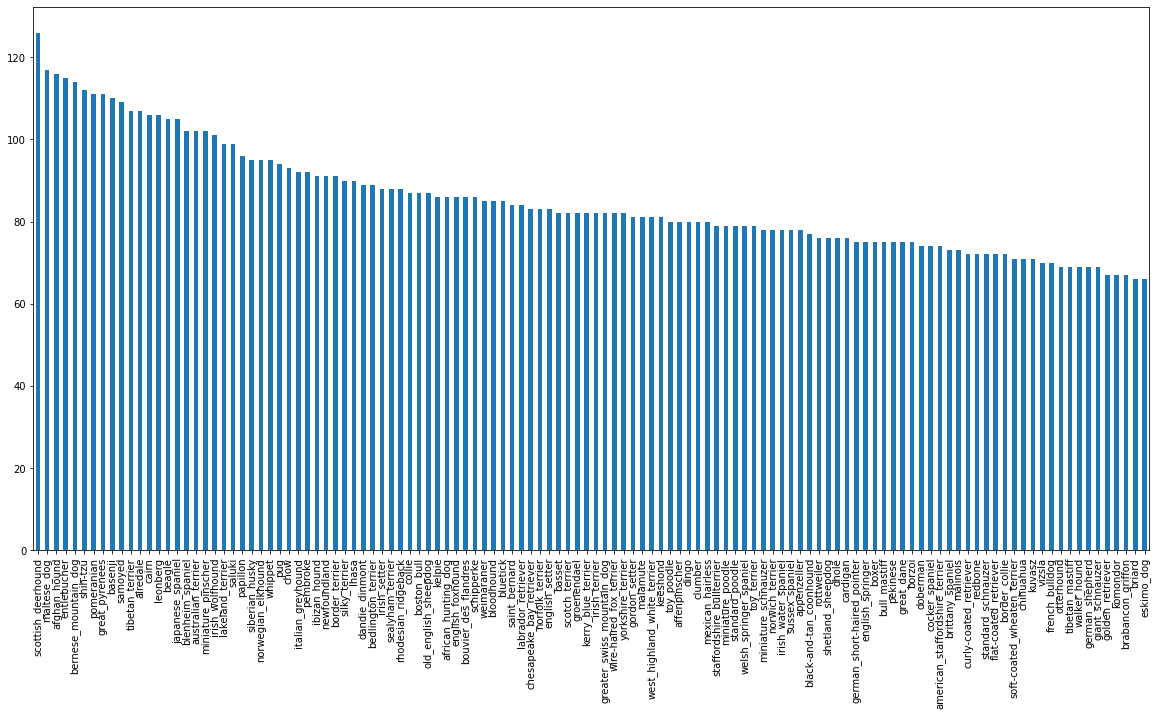

In [119]:
# how many images are there for each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [120]:
labels_csv["breed"].value_counts().median()

82.0

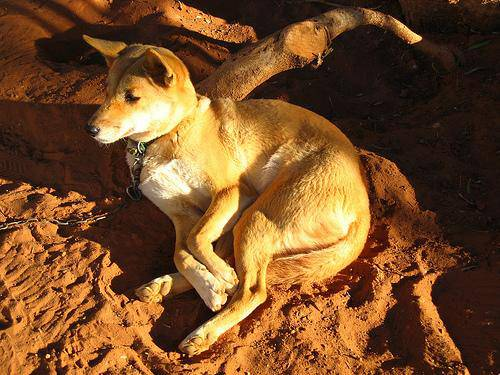

In [121]:
# Lets view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Getting images and their labels
### Lets get a list of all our image file pathnames

In [122]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [123]:
# create pathnames for images IDs
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [124]:
labels_csv[:10]

id               breed
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo
2  001cdf01b096e06d78e9e5112d419397            pekinese
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier
7  002a283a315af96eaea0e28e7163b21b              borzoi
8  003df8b8a8b05244b1d920bb6cf451f9             basenji
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound

In [125]:
# check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files !! Proceed")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files !! Proceed


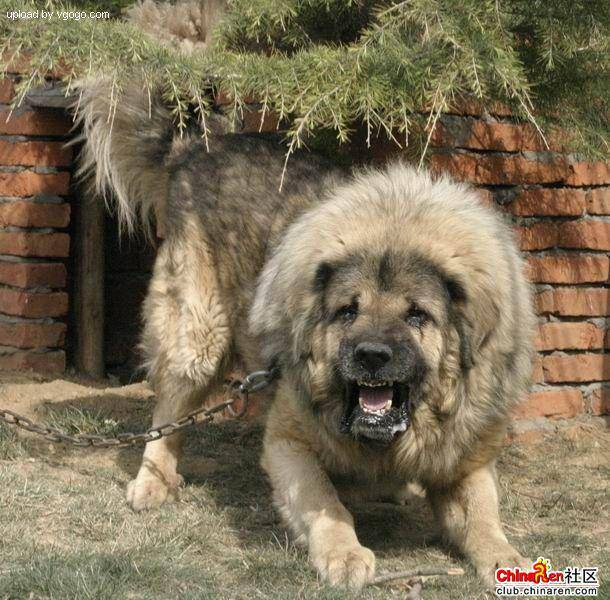

In [126]:
# One more check 
Image(filenames[9000])

In [127]:
labels_csv.breed[9000]

'tibetan_mastiff'

Since we have now got our training image filepaths in a list, lets prepare our labels

In [128]:
import numpy as np

labels = labels_csv.breed.to_numpy()
#labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [129]:
len(labels)

10222

In [130]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames


In [131]:
# find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [132]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [133]:
# Turn every label into an boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2], len(boolean_labels)

([array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False]),
  array([False, False, False, Fa

In [134]:
# Example:Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will bei a 1 where the sample occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [135]:
boolean_labels_int = [i.astype(int) for i in boolean_labels]
boolean_labels_int[:2]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

### Creating our own validation set
Since the dataset from Kaggle does not come with a validation set, we are going to create our own

In [136]:
# Setup X & y variables
X  = filenames
y = boolean_labels

In [137]:
len(filenames)

10222

We are going to start off experimenting with ~1000 images and increase as needed

In [138]:
# Set number of images to use experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step: 1000}

In [139]:
# Lets split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                    y[:NUM_IMAGES],
                                                    test_size= 0.2,
                                                    random_state = 42)

len(X_train), len(y_train), len(X_val), len(y_val)



(800, 800, 200, 200)

In [140]:
# lets hava a geez at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

To preprocess out images into Tensors we are going to write a function which doees a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, ***image***
3. Turn our ***image*** ( a jpg) into Tensors
4. Resize the ***image*** to be a shape of (224,224)
5. Return modified ***image***

Before we do, lets see what importing an image looks like

In [141]:
# convert an image to an numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [142]:
# turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [143]:
image_1 = tf.constant(imread(filenames[43]))
image_1[:2]

<tf.Tensor: shape=(2, 401, 3), dtype=uint8, numpy=
array([[[178, 165, 131],
        [179, 166, 132],
        [182, 167, 134],
        ...,
        [ 59,  45,  36],
        [ 53,  39,  30],
        [ 38,  30,  19]],

       [[176, 163, 129],
        [178, 165, 131],
        [180, 165, 132],
        ...,
        [ 61,  47,  38],
        [ 55,  41,  32],
        [ 40,  32,  21]]], dtype=uint8)>

Now weve seen what an image looks like as a Tensor, lets make a function to preprocess them 

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, ***image***
3. Turn our ***image*** ( a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the ***image*** to be a shape of (224,224)
6. Return modified ***image***

In [144]:
#Define image size
IMG_SIZE = 224

#Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  #Turn th jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32) 
  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image,size=[IMG_SIZE, IMG_SIZE])
  
  return image

In [145]:
tensor_image = process_image(filenames[0])
tensor_image[:2]

<tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
array([[[0.5705322 , 0.33588538, 0.15008473],
        [0.66901225, 0.4601166 , 0.26022965],
        [0.61062384, 0.43763596, 0.21601713],
        ...,
        [0.8182312 , 0.7297958 , 0.26963907],
        [0.72454786, 0.6059109 , 0.2653059 ],
        [0.7494603 , 0.6252918 , 0.32456532]],

       [[0.6761415 , 0.4733761 , 0.30642927],
        [0.5672121 , 0.38192675, 0.20349538],
        [0.5883547 , 0.4322571 , 0.2403155 ],
        ...,
        [0.9326942 , 0.8260503 , 0.41093278],
        [0.86072475, 0.74250627, 0.3694122 ],
        [0.76781666, 0.6461604 , 0.29291284]]], dtype=float32)>

## Turning our data into batches 

Why turn our data into batches?

Lets say your trying to precess 10000+ images in one go... they al might not into memory.

So thats why we do about 32 (this is batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we nee our data in the form of Tensor tuples which look like this:
***(image, label)***

In [146]:
# Create a simle function to retrun a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image,label

In [147]:
# Demo of above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now weve got a way to turn our data into tuples of Tensors in the form: ***(image, label)***, lets make a function to turn all of our data (X&Y) into batches

In [213]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image(X) and label (y) pairs.
  Shuffles the data if its training data but doesnt shuffle if its validation data
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably dont have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch 

  # If the data is a valid dataset, we dont need to shuffle it
  if valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image,label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [149]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [150]:
# check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, lets visualize them

In [151]:
import matplotlib.pyplot as plt

#Creat a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Creat subplots ( 5rows, 5 columsn)
    ax = plt.subplot(5,5,i+1)
    #Display an image
    plt.imshow(images[i])
    # Add the image label as the title - For understanding try unique_breeds[y[0].argmax()]
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

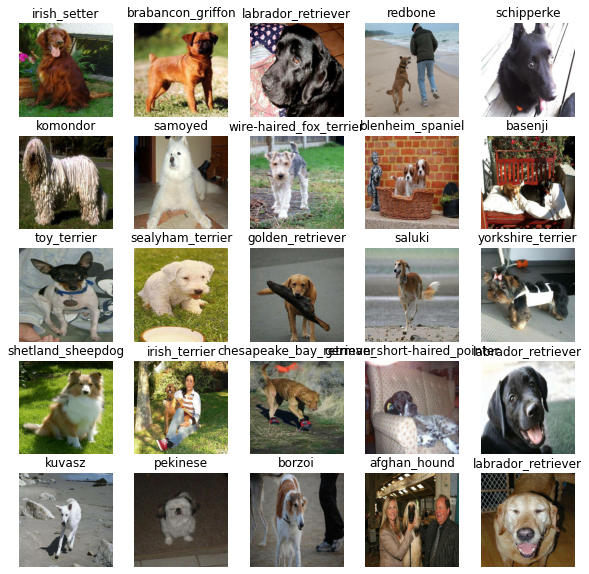

In [152]:
# Now lets visualize the data in a training batch - note the order is changing every time we run the code because of the shuffling we did back there
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

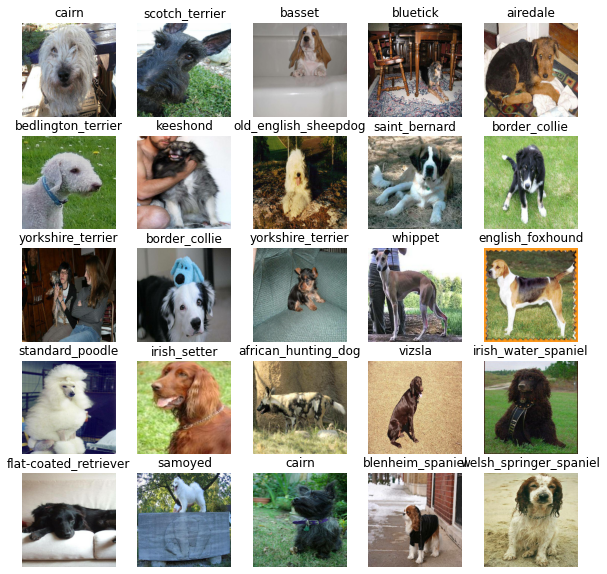

In [153]:
# Now lets visualize our validation data - not the picture keep into the same order because we didnt shuffle the data
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model
Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model
* The URL of the model we want to use

In [154]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model 
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now weve got our inputs, outputs and model ready to go.
Lets put them together into Keras deep learning model!

Knowing this, lets create a function which:
* Takes the input shape, output shape and the model we have chosen as parameters
* Defines the Layers in a Keras model in seqeuntial fashion (do this than that then that)
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it will be getting)
* Returns the model

All of these steps can be found at tensorflow.org/guide/keras/overview

In [155]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with ", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 Input Layer
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax") # Layer 2 output layer
  ])

  # compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer= tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [156]:
model = create_model()
model.summary()

Building model with  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  5432713   
_________________________________________________________________
dense_2 (Dense)              multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Create callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving

We will create two callbacks, one for Tensorboard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoardCallback

To setup a tensorboard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension (done)
2. Create a TensorBoard notebook which is able to save logs to a directory and pass it to our models fit() function. (done)
3. Visualize our model training logs with the %tensorboard magic function(well do this after model traning)

In [157]:
# Load TensorBoard notebook extension

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [158]:
import datetime

# Create a function to build a Tensorboard callback
def create_tensorboard_callback():
  # Create a log directory 
  logdir = os.path.join("drive/My Drive/Dog Vision/logs", 
                        #make it so the logs get tracked whenever we run a experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [159]:
# create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images to make sure everthing is working

In [160]:
# number of epochs is how many parse of the data wed like our model to do
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step: 10}

In [161]:
# check to make sure we are still runing on a GPU
print("GPU", "available YEEEESSS" if tf.config.list_physical_devices("GPU") else "not available")

GPU available YEEEESSS


Lets create a function which trains a model

* Creat a model using create_model()
* Setup a Tensorboard callback using create_tensorboard_callback()
* Call the fit() function on our model passing it the training, data validation data, number o epochs to train for (NUM_EPOCHS) and the callback wed like to use
* Return the model

In [162]:
# build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  #Create a model 
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  #Fit the model to the data passing in the callbacks we created
  model.fit(x= train_data,
            epochs= NUM_EPOCHS,
            validation_data = val_data, 
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  #Return the fitted moedl 
  return model

In [163]:
#Fit the model to the data
model = train_model()

Building model with  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 2/25 [=>............................] - ETA: 8s - loss: 6.0513 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.315201). Check your callbacks.


25/25 [==============================] - 6s 229ms/step - loss: 4.6762 - accuracy: 0.0787 - val_loss: 3.3741 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 5s 201ms/step - loss: 1.6528 - accuracy: 0.6862 - val_loss: 2.1689 - val_accuracy: 0.4800
Epoch 3/100
25/25 [==============================] - 5s 202ms/step - loss: 0.5623 - accuracy: 0.9400 - val_loss: 1.6873 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 5s 198ms/step - loss: 0.2481 - accuracy: 0.9912 - val_loss: 1.4941 - val_accuracy: 0.6100
Epoch 5/100
25/25 [==============================] - 5s 196ms/step - loss: 0.1459 - accuracy: 0.9962 - val_loss: 1.4164 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 5s 194ms/step - loss: 0.0996 - accuracy: 1.0000 - val_loss: 1.3851 - val_accuracy: 0.6400
Epoch 7/100
25/25 [==============================] - 5s 197ms/step - loss: 0.0754 - accuracy: 1.0000 - val_loss: 1.3505 - val_accuracy: 0.6350
Epoch 8/100

**Question:** It looks like our model is overfitting because it is performing far better on the training dataset than validation dataset, what are some ways to prevent omodel overfitting in deep learning neural networks

**Note:** Overfittin to begin with is a good thing! It means our model is learning

### Checking the TensorBoard logs

The tensorboard magic function (%tensorboard) will acces the logs directory we created earlier and visualize its contents

In [164]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

Output hidden; open in https://colab.research.google.com to view.

## Making and evaluating predictions using a trained model

In [165]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 119ms/step


array([[3.73612833e-03, 1.16081195e-04, 1.88017043e-03, ...,
        1.61363336e-04, 5.28198834e-05, 1.18537608e-03],
       [2.36831070e-03, 1.81743200e-03, 1.26641300e-02, ...,
        7.40023679e-04, 1.45678665e-03, 4.82768461e-04],
       [5.47044510e-06, 5.27649499e-05, 9.37439381e-06, ...,
        2.30965197e-05, 3.43758293e-05, 2.33637384e-05],
       ...,
       [3.89949601e-05, 9.98669930e-05, 3.02381322e-05, ...,
        2.61290843e-04, 2.35900865e-04, 1.16832089e-04],
       [1.63488113e-03, 1.26883373e-04, 2.04496537e-04, ...,
        4.09713284e-05, 6.71203088e-05, 6.36585150e-03],
       [4.36794304e-04, 4.02347723e-05, 1.35721290e-03, ...,
        8.19723122e-03, 1.46392221e-03, 2.12967207e-04]], dtype=float32)

In [166]:
predictions.shape

(200, 120)

In [167]:
# first prediction
index=42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[2.41780363e-04 3.51962051e-04 4.71443673e-05 2.00202674e-04
 2.59619928e-03 1.14778282e-04 3.01827560e-04 1.73382938e-03
 2.25180537e-02 5.18864132e-02 1.06617837e-04 2.02536576e-05
 7.25452497e-04 1.48729142e-02 1.49703166e-03 5.27616916e-03
 8.73267927e-05 8.60211730e-04 1.64098848e-04 1.07431097e-03
 1.86412144e-04 1.50842068e-03 4.67249702e-05 3.58893230e-05
 4.16682707e-03 7.61453412e-05 9.73353744e-05 1.68009559e-04
 5.80034452e-04 2.03791802e-04 5.30569669e-05 4.19378688e-04
 1.96906782e-04 1.68867264e-05 3.19451428e-05 6.92420435e-05
 1.19872054e-03 4.05197032e-04 1.05522216e-04 1.25355810e-01
 3.20218998e-04 1.05406498e-05 8.21383670e-03 6.09447034e-06
 9.59114477e-05 2.78657571e-05 2.80544249e-04 2.25913688e-03
 5.91209500e-05 2.89797550e-04 2.16459113e-04 4.43875324e-05
 5.93060395e-04 7.85318948e-03 1.32478788e-04 1.01388223e-03
 1.53384797e-04 1.47524755e-04 6.25381581e-05 7.71100968e-05
 1.02420789e-04 9.70176887e-04 8.81321830e-06 1.06628919e-04
 9.56563570e-04 7.025977

Having the above functionality is great but we want to be able to do it on scale.

And it would be even better if we could see the image the prediction is being made on

**Note:** Prediction probabilities are also known as confidance levels 

In [168]:
# Turn prediction probabilities into the respective label (easier to understand)

def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[42])
pred_label

'walker_hound'

Now since our validation data is still in a batch dataset, we will have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels(truth labels)

In [169]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [170]:
images_ = []
labels_ = []

# loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [171]:
# look in an example if our model was right
print(get_pred_label(labels_[42]))
print(get_pred_label(predictions[42]))

english_foxhound
walker_hound


In [172]:
# Creat a function to unbatch a batch dataset - Udemy solution

def unbatchifyU(data):
  """
  Takes a batched dataset of (image,label) Tensors and returns separate arrays of images and labels
  """
  images = []
  labels = []
  #Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

#Unbatchify th validation data
val_images, val_labels = unbatchifyU(val_data)
val_images[0], val_labels[0]



(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [173]:
# Create a function to compare predictions and validations

INDEX = 42

def compareResults(prediction_probabilities, labels, val_data, index= INDEX):
  predicted = labels[np.argmax(prediction_probabilities[index])]
  images_ = []
  labels_ = []
  for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label) 
  validation = labels[np.argmax(labels_[index])]
  return predicted, validation

In [190]:
compareResults(predictions, unique_breeds, val_data, index=82)

('pekinese', 'pekinese')

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images
Lets make some function to make these all a bit more visualize

We will create a function which:
* takes an arraay of prediction probabilities, an array of truth labels and an array of image and integer (done)
* Convert the prediction probabilities to a predicted label (done)
* Plot the predicte label, its predicted probability, the truth label and the target image on a single plot (done)

In [175]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth an image for sample n
  """
  pred_prob, true_label, image= prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color= "red"

  # Change plot title to be predicted, probability of prediciton and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                   np.max(pred_prob)*100,
                                   true_label),
              color=color)
  

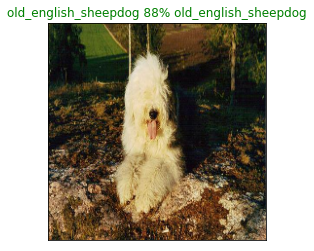

In [195]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images, n=7)

Now we've got one function to visualize our models  top prediction, lets make another to view our models top 10 predictions

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using get_pred_label()
* Find the top 10:
  * Prediction probabilities indexes
  * Predition probabilities values
  * Prediction labels
* plot the top 10 prediction probability vaalues and labels, coloring the tur label green

In [177]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidence along with the truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find thet top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_indexes)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

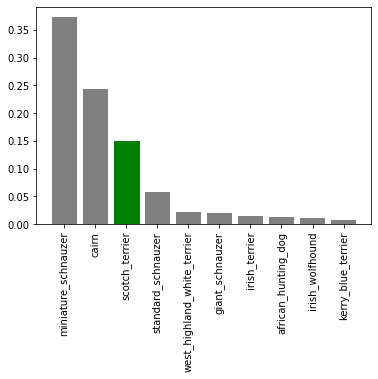

In [197]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=1)

Now we have got some functions to help us visualize our predictions and evaluate our model, lets check out a few.

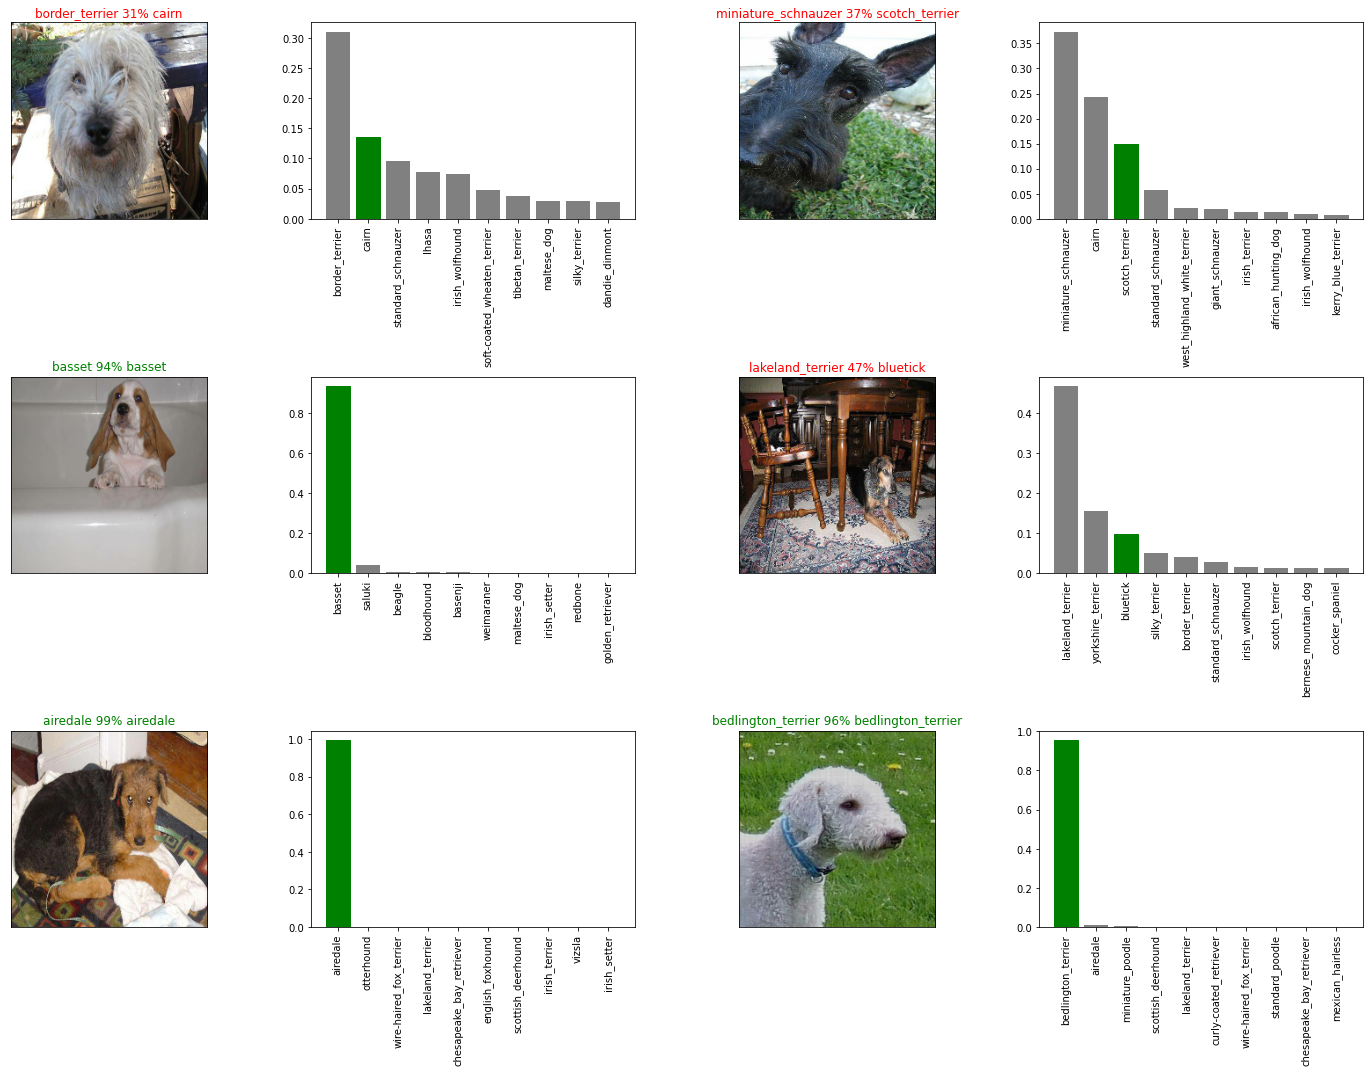

In [198]:
# Lets check out a few predictions and their different values
i_multiplier = 0 
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2* num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

### Saving and reloading a trained model 

In [180]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models/", 
                          datetime.datetime.now().strftime("%Y%m%d-%H&M&s"))
  model_path = modeldir + "-" +suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [181]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """ 
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                              custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we have got functions to save and load a trained model, lets make sure they work

In [182]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200629-07&M&s-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200629-07&M&s-1000-images-mobilenetv2-Adam.h5'

In [184]:
# load a trained model 
loaded_1000_image_model = load_model("drive/My Drive/Dog Vision/models/20200629-07&M&s-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Dog Vision/models/20200629-07&M&s-1000-images-mobilenetv2-Adam.h5


In [185]:
# Evaluate the pre-saved model 
model.evaluate(val_data)

7/7 [==============================] - 1s 109ms/step - loss: 1.2888 - accuracy: 0.6450


[1.2887845039367676, 0.6449999809265137]

In [186]:
# evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 109ms/step - loss: 1.2888 - accuracy: 0.6450


[1.2887845039367676, 0.6449999809265137]

## Training a big dog model (on the full data)

In [201]:
len(X), len(y)

(10222, 10222)

In [203]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [204]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [205]:
full_model = create_model()

Building model with  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [206]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we cant monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we are using in the runtime has to load all of the images into memory  

In [208]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 6728s 21s/step - loss: 1.3427 - accuracy: 0.6651
Epoch 2/100
320/320 [==============================] - 48s 150ms/step - loss: 0.3992 - accuracy: 0.8818
Epoch 3/100
320/320 [==============================] - 48s 149ms/step - loss: 0.2348 - accuracy: 0.9364
Epoch 4/100
320/320 [==============================] - 48s 150ms/step - loss: 0.1544 - accuracy: 0.9617
Epoch 5/100
320/320 [==============================] - 49s 154ms/step - loss: 0.1063 - accuracy: 0.9789
Epoch 6/100
320/320 [==============================] - 48s 151ms/step - loss: 0.0770 - accuracy: 0.9872
Epoch 7/100
320/320 [==============================] - 48s 151ms/step - loss: 0.0582 - accuracy: 0.9917
Epoch 8/100
320/320 [==============================] - 48s 150ms/step - loss: 0.0469 - accuracy: 0.9944
Epoch 9/100
320/320 [==============================] - 48s 151ms/step - loss: 0.0372 - accuracy: 0.9957
Epoch 10/100
320/320 [==============================] - 49s 152m

In [209]:
save_model(full_model, suffix="full_image_set_mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200629-10&M&s-full_image_set_mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200629-10&M&s-full_image_set_mobilenetv2-Adam.h5'

In [302]:
#Load in the full model
loaded_full_model = load_model("drive/My Drive/Dog Vision/models/20200629-10&M&s-full_image_set_mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Dog Vision/models/20200629-10&M&s-full_image_set_mobilenetv2-Adam.h5


Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to makepredictions on the test data, we will have to get it into the same format.

Luckily we created create_data_batches() earlier which kcan take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get te test image filnames
* convert the filenames into test data batches using create_date_batches() and setting the test_data parameter to True (since the test data doenst have labels)
* Make a predictions array by passing the test batches to the predict() method called on our model

In [211]:
# Load test image filenames
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/ee18a2bf52ba6ae53327c951c94d598e.jpg',
 'drive/My Drive/Dog Vision/test/ea1e945b924638c2059d7718b522d48f.jpg',
 'drive/My Drive/Dog Vision/test/efac70ee513c40265966b89d715f183e.jpg',
 'drive/My Drive/Dog Vision/test/f47e4614a5d7d190cf95b4b9c1e78576.jpg',
 'drive/My Drive/Dog Vision/test/f14ba73b3323b3c7cfc3ba359a6c4313.jpg',
 'drive/My Drive/Dog Vision/test/f1eadf24d904d3c1e26d8081555901be.jpg',
 'drive/My Drive/Dog Vision/test/f082ee9b91ad597fdf11cc08771bbb50.jpg',
 'drive/My Drive/Dog Vision/test/f51f6aeea8a23b6bd62728fde8f04ad8.jpg',
 'drive/My Drive/Dog Vision/test/ecb6362d105c0cb84d8e69cfd9b8d0b5.jpg',
 'drive/My Drive/Dog Vision/test/f02444318adc0c1c2360c3bf3bff5709.jpg']

In [214]:
#Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [215]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling predict() on our full model and passing it the test data batch will take a long time to run (abount an ~1hour)

In [216]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 7692s 24s/step


In [219]:
# Save predictions (Numpy array) to csv file (for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [220]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [224]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

To get data in this format, we will:
* Create a pandas DataFRame with an ID column as well as a column for each dog breed
* Add data to the ID column by extrachting the test image IDs from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns 
* Export the DataFrame as a CSV to submit it to Kaggle

In [225]:
# Create a pandas DataFrame with empty columns 
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [230]:
# Append test image IDs to predictions DataFRame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [231]:
preds_df.head()

id  ... yorkshire_terrier
0  ee18a2bf52ba6ae53327c951c94d598e  ...               NaN
1  ea1e945b924638c2059d7718b522d48f  ...               NaN
2  efac70ee513c40265966b89d715f183e  ...               NaN
3  f47e4614a5d7d190cf95b4b9c1e78576  ...               NaN
4  f14ba73b3323b3c7cfc3ba359a6c4313  ...               NaN

[5 rows x 121 columns]

In [232]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  ee18a2bf52ba6ae53327c951c94d598e  ...       2.81638e-07
1  ea1e945b924638c2059d7718b522d48f  ...        2.7508e-10
2  efac70ee513c40265966b89d715f183e  ...       5.67284e-09
3  f47e4614a5d7d190cf95b4b9c1e78576  ...       2.12271e-08
4  f14ba73b3323b3c7cfc3ba359a6c4313  ...       2.31604e-09

[5 rows x 121 columns]

Save our predictions dataframe to CSV for submission to Kaggle

In [240]:
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images 

To make predictions on custom images, we will:
* Get the filepaths of our own images
* Turn the filpaths into data batches using create_data_batches(). And since our custom images wont have labels, we set the test_data parameter to True
* Pass the custom image data batch to our models predict() method
* Convert the prediction output probabilities to predictions labels
* Compare the predicted labels to the custom images


In [326]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths.remove('drive/My Drive/Dog Vision/my-dog-photos/.ipynb_checkpoints')
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/dog-photo-2.jpeg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-1.jpeg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-3.jpeg',
 'drive/My Drive/Dog Vision/my-dog-photos/yorki.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/schaefer.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/goldi.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/huso.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/börni.jpg']

In [327]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [328]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [329]:
custom_preds.shape

(8, 120)

In [330]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['lakeland_terrier',
 'golden_retriever',
 'labrador_retriever',
 'yorkshire_terrier',
 'german_shepherd',
 'golden_retriever',
 'redbone',
 'bernese_mountain_dog']

In [331]:
# Get custom images (our unbatchify() fuction wont work since there arent labels...maybe fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

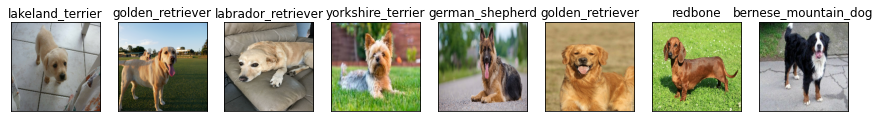

In [332]:
# Check custom predictions
plt.figure(figsize=(15,15))
for i, image in enumerate(custom_images):
  plt.subplot(1,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  #plt.tight_layout()
  plt.imshow(image)